# Image Classification Based on Unlabeled Data (SM GroundTruth via GUI), and SM Built-in Algorithm for Transfer Learning


PA2, 2021-06-17

Adapted from: https://github.com/aws/amazon-sagemaker-examples/blob/master/ground_truth_labeling_jobs/from_unlabeled_data_to_deployed_machine_learning_model_ground_truth_demo_image_classification/from_unlabeled_data_to_deployed_machine_learning_model_ground_truth_demo_image_classification.ipynb 

In [2]:
import itertools
import boto3

# Download and process the Open Images annotations
!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-human-imagelabels-boxable.csv -O openimgs-annotations.csv
with open('openimgs-annotations.csv', 'r') as f:
    all_labels = [line.strip().split(',') for line in f.readlines()]
    
 # Extract image ids in each of our desired classes
ims = {}
ims['Truck'] = [label[0] for label in all_labels if (label[2] == '/m/07r04' and label[3] == '1')][:5]
ims['Limousine'] = [label[0] for label in all_labels if (label[2] == '/m/01lcw4' and label[3] == '1')][:5]
ims['Van'] = [label[0] for label in all_labels if (label[2] == '/m/0h2r6' and label[3] == '1')][:5]
ims['Car'] = [label[0] for label in all_labels if (label[2] == '/m/0pg52' and label[3] == '1')][:5]
ims['Motorcycle'] = [label[0] for label in all_labels if (label[2] == '/m/04_sv' and label[3] == '1')][:5]
num_classes = len(ims)

# Prepare data and upload to your S3 bucket
BUCKET = 'prj-ml'
EXP_NAME = 'ground-truth-demo-hba-5vehicles' # Any valid S3 prefix.
for key in ims.keys():
    ims[key] = set(ims[key])

# Create a new bucket for images to be labeled
s3 = boto3.client('s3')
sess = boto3.session.Session()
region = sess.region_name
if (region == 'us-east-1'):
    s3.create_bucket(Bucket=BUCKET)
else:
    s3.create_bucket(Bucket=BUCKET, 
                        CreateBucketConfiguration={'LocationConstraint': region})

# Copy the images to your local bucket
for img_id, img in enumerate(itertools.chain.from_iterable(ims.values())):
    copy_source = {
        'Bucket': 'open-images-dataset',
        'Key': 'test/{}.jpg'.format(img)
    }
    s3.copy(copy_source, BUCKET, '{}/images/{}.jpg'.format(EXP_NAME, img))

--2021-06-17 16:59:08--  https://storage.googleapis.com/openimages/2018_04/test/test-annotations-human-imagelabels-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26460276 (25M) [text/csv]
Saving to: ‘openimgs-annotations.csv’

openimgs-annotation 100%[===================>]  25.23M   149MB/s    in 0.2s    

2021-06-17 16:59:08 (149 MB/s) - ‘openimgs-annotations.csv’ saved [26460276/26460276]



In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from collections import namedtuple
from collections import defaultdict
from collections import Counter
import itertools
import json
import random
import time
import imageio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
import boto3
import sagemaker
from urllib.parse import urlparse


BUCKET = "prj-ml"
assert BUCKET != "<< YOUR S3 BUCKET NAME >>", "Please provide a custom S3 bucket name."
EXP_NAME = "ground-truth-demo-hba-5vehicles"  # Any valid S3 prefix.
# RUN_FULL_AL_DEMO = True  # See 'Cost and Runtime' in the Markdown cell above!
RUN_FULL_AL_DEMO = False  # See 'Cost and Runtime' in the Markdown cell above!

In [12]:
BUCKET, EXP_NAME

('prj-ml', 'ground-truth-demo-hba-5vehicles')

In [5]:
# Make sure the bucket is in the same region as this notebook.
# role = sagemaker.get_execution_role()
role = 'arn:aws:iam::*******580:role/service-role/AmazonSageMaker-ExecutionRole-20180314T175147'
region = boto3.session.Session().region_name
s3 = boto3.client("s3")
bucket_region = s3.head_bucket(Bucket=BUCKET)["ResponseMetadata"]["HTTPHeaders"][
    "x-amz-bucket-region"
]
assert (
    bucket_region == region
), "You S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

After running the cell above, you should be able to go to `s3://BUCKET/EXP_NAME/images` in [S3 console](https://console.aws.amazon.com/s3/) and see a thousand images. We recommend you inspect the contents of these images! You can download them all to a local machine using the AWS CLI.

## Specify the categories
To run an image classification labeling job, you need to decide on a set of classes the annotators can choose from. 
In our case, this list is `["Musical Instrument", "Fruit", "Cheetah", "Tiger", "Snowman"]`. In your own job you can choose any list of up to 10 classes. We recommend the classes to be as unambiguous and concrete as possible. The categories should be mutually exclusive, with only one correct label per image. In addition, be careful to make the task as *objective* as possible, unless of course your intention is to obtain subjective labels.
* Example good category lists: `["Human", "No Human"]`, `["Golden Retriever", "Labrador", "English Bulldog", "German Shepherd"]`, `["Car", "Train", "Ship", "Pedestrian"]`.
* Example bad category lists: `["Prominent object", "Not prominent"]` (meaning unclear), `["Beautiful", "Ugly"]` (subjective), `["Dog", "Animal", "Car"]` (not mutually exclusive). 

To work with Ground Truth, this list needs to be converted to a .json file and uploaded to the S3 `BUCKET`.

*Note: The ordering of the labels or classes in the template governs the class indices that you will see downstream in the output manifest (this numbering is zero-indexed). In other words, the class that appears second in the template will correspond to class "1" in the output. At the end of this demonstration, we will train a model and make predictions, and this class ordering is instrumental to interpreting the results.*

In [41]:
CLASS_LIST = list(['Car', 'Bike','Van','Truck','Limousine'])
print("Label space is {}".format(CLASS_LIST))


Label space is ['Car', 'Bike', 'Van', 'Truck', 'Limousine']


In [42]:
CLASS_LIST

['Car', 'Bike', 'Van', 'Truck', 'Limousine']

You should now be able to find your template in `s3://BUCKET/EXP_NAME/instructions.template`.

In [11]:
manifest_name = "input.manifest"

In [33]:
job_name = 'vehicle-labeling-demo-hba-5vehicles'

You can re-evaluate the next cell repeatedly. It sends a `describe_labelging_job` request which should tell you whether the job is completed or not. If it is, then 'LabelingJobStatus' will be 'Completed'.

# Train an image classifier using Ground Truth labels
At this stage, we have fully labeled our dataset and we can train a machine learning model to classify images based on the categories we previously defined. We'll do so using the **augmented manifest** output of our labeling job - no additional file translation or manipulation required! For a more complete description of the augmented manifest, see our other [example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/ground_truth_labeling_jobs/object_detection_augmented_manifest_training/object_detection_augmented_manifest_training.ipynb).

**NOTE:** Training neural networks to high accuracy often requires a careful choice of hyperparameters. In this case, we hand-picked hyperparameters that work reasonably well for this dataset. The neural net should have accuracy of about **60% if you're using 100 datapoints, and over 95% if you're using 1000 datapoints.**. To train neural networks on novel data, consider using [SageMaker's model tuning / hyperparameter optimization algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html).

First, we'll split our augmented manifest into a training set and a validation set using an 80/20 split.

Next, we'll upload these manifest files to the previously defined S3 bucket so that they can be used in the training job.

In [11]:
# # Load the output manifest's annotations.
# OUTPUT_MANIFEST = "s3://{}/{}/output/{}/manifests/output/output.manifest".format(
#     BUCKET, EXP_NAME, job_name
# )

# !aws s3 cp {OUTPUT_MANIFEST} 'output.manifest'
!aws s3 cp s3://prj-ml/ground-truth-demo-hba-5vehicles/labeled_data/vehicle-labeling-demo-hba-5vehicles/manifests/output/output.manifest 'output.manifest'

download: s3://prj-ml/ground-truth-demo-hba-5vehicles/labeled_data/vehicle-labeling-demo-hba-5vehicles/manifests/output/output.manifest to ./output.manifest


In [10]:
with open("output.manifest", "r") as f:
    output = [json.loads(line) for line in f.readlines()]

# Shuffle output in place.
np.random.shuffle(output)

dataset_size = len(output)
train_test_split_index = round(dataset_size * 0.8)

train_data = output[:train_test_split_index]
validation_data = output[train_test_split_index:]

num_training_samples = 0
with open("train.manifest", "w") as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write("\n")
        num_training_samples += 1

with open("validation.manifest", "w") as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write("\n")

In [22]:
s3.upload_file("train.manifest", BUCKET, EXP_NAME + "/train.manifest")
s3.upload_file("validation.manifest", BUCKET, EXP_NAME + "/validation.manifest")



{
  "source-ref": "s3://prj-ml/ground-truth-demo-hba-5vehicles/images/02c41bf9d19fbae4.jpg",
  "category": 1,
  "vehicle-labeling-demo-hba-5vehicles-metadata": {
    "class-name": "Bike",
    "job-name": "labeling-job/vehicle-labeling-demo-hba-5vehicles",
    "confidence": 0,
    "type": "groundtruth/image-classification",
    "human-annotated": "yes",
    "creation-date": "2021-06-17T17:09:12.367759"
  }
}

In [23]:
num_classes = 5

In [28]:
# Create unique job name
nn_job_name_prefix = "groundtruth-demo-hba-5vehicles"
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
nn_job_name = nn_job_name_prefix + timestamp

training_image = sagemaker.amazon.amazon_estimator.get_image_uri(
    boto3.Session().region_name, "image-classification", repo_version="latest"
)

training_params = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "Pipe"},
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output/".format(BUCKET, EXP_NAME)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.p3.2xlarge", "VolumeSizeInGB": 50},
    "TrainingJobName": nn_job_name,
    "HyperParameters": {
        "epochs": "30",
        "image_shape": "3,224,224",
        "learning_rate": "0.01",
        "lr_scheduler_step": "10,20",
        "mini_batch_size": "4",
        "num_classes": str(num_classes),
        "num_layers": "18",
        "num_training_samples": str(num_training_samples),
        "resize": "224",
        "use_pretrained_model": "1",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 86400},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": "s3://{}/{}/{}".format(BUCKET, EXP_NAME, "train.manifest"),
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": ["source-ref", "category"],
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": "s3://{}/{}/{}".format(BUCKET, EXP_NAME, "validation.manifest"),
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": ["source-ref", "category"],
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None",
        },
    ],
}

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Now we create the SageMaker training job.

In [29]:
training_params

{'AlgorithmSpecification': {'TrainingImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1',
  'TrainingInputMode': 'Pipe'},
 'RoleArn': 'arn:aws:iam::*******0580:role/service-role/AmazonSageMaker-ExecutionRole-20180314T175147',
 'OutputDataConfig': {'S3OutputPath': 's3://prj-ml/ground-truth-demo-hba-5vehicles/output/'},
 'ResourceConfig': {'InstanceCount': 1,
  'InstanceType': 'ml.p3.2xlarge',
  'VolumeSizeInGB': 50},
 'TrainingJobName': 'groundtruth-demo-hba-5vehicles-2021-06-17-18-33-51',
 'HyperParameters': {'epochs': '30',
  'image_shape': '3,224,224',
  'learning_rate': '0.01',
  'lr_scheduler_step': '10,20',
  'mini_batch_size': '4',
  'num_classes': '5',
  'num_layers': '18',
  'num_training_samples': '20',
  'resize': '224',
  'use_pretrained_model': '1'},
 'StoppingCondition': {'MaxRuntimeInSeconds': 86400},
 'InputDataConfig': [{'ChannelName': 'train',
   'DataSource': {'S3DataSource': {'S3DataType': 'AugmentedManifestFile',
     'S3Uri': 's3://prj-ml/

In [30]:
sagemaker_client = boto3.client("sagemaker")
sagemaker_client.create_training_job(**training_params)

# Confirm that the training job has started
print("Training job started")
while True:
    status = sagemaker_client.describe_training_job(TrainingJobName=nn_job_name)[
        "TrainingJobStatus"
    ]
    if status == "Completed":
        print("Transform job ended with status: " + status)
        break
    if status == "Failed":
        message = response["FailureReason"]
        print("Transform failed with the following error: {}".format(message))
        raise Exception("Transform job failed")
    time.sleep(30)

Training job started
Transform job ended with status: Completed


# Deploy the Model 

Now that we've fully labeled our dataset and have a trained model, we want to use the model to perform inference.

Image classification only supports encoded .jpg and .png image formats as inference input for now. The output is the probability values for all classes encoded in JSON format, or in JSON Lines format for batch transform.

This section involves several steps,

    Create Model - Create model for the training output
    Batch Transform - Create a transform job to perform batch inference.
    Host the model for realtime inference - Create an inference endpoint and perform realtime inference.

## Create Model

In [31]:
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
model_name = "groundtruth-demo-hba-5vehicles" + timestamp
print(model_name)
info = sagemaker_client.describe_training_job(TrainingJobName=nn_job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

primary_container = {
    "Image": training_image,
    "ModelDataUrl": model_data,
}

create_model_response = sagemaker_client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

groundtruth-demo-hba-5vehicles-2021-06-17-18-41-31
s3://prj-ml/ground-truth-demo-hba-5vehicles/output/groundtruth-demo-hba-5vehicles-2021-06-17-18-33-51/output/model.tar.gz
arn:aws:sagemaker:us-east-1:********0580:model/groundtruth-demo-hba-5vehicles-2021-06-17-18-41-31


## Batch Transform
We now create a SageMaker Batch Transform job using the model created above to perform batch prediction.

### Download Test Data
First, let's download a test image that has been held out from the training and validation data.

In [ ]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = "image-classification-model-hba-5vehicles" + timestamp
batch_input = 's3://{}/{}/test/'.format(BUCKET, EXP_NAME)
batch_output = 's3://{}/{}/{}/output/'.format(BUCKET, EXP_NAME, batch_job_name)

# Copy two images from each class, unseen by the neural net, to a local bucket.
test_images = []
for class_id in ['/m/04szw', '/m/02xwb', '/m/0cd4d', '/m/07dm6', '/m/0152hh']:
    test_images.extend([label[0] + '.jpg' for label in all_labels if (label[2] == class_id and label[3] == '1')][-2:])
    
!aws s3 rm $batch_input --recursive
for test_img in test_images:
    !aws s3 cp s3://open-images-dataset/test/{test_img} {batch_input}

In [ ]:
request = {
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/{}/output/".format(BUCKET, EXP_NAME, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": batch_input}},
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None",
    },
    "TransformResources": {"InstanceType": "ml.p2.xlarge", "InstanceCount": 1},
}

print("Transform job name: {}".format(batch_job_name))

In [ ]:
sagemaker_client = boto3.client("sagemaker")
sagemaker_client.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while True:
    response = sagemaker_client.describe_transform_job(TransformJobName=batch_job_name)
    status = response["TransformJobStatus"]
    if status == "Completed":
        print("Transform job ended with status: " + status)
        break
    if status == "Failed":
        message = response["FailureReason"]
        print("Transform failed with the following error: {}".format(message))
        raise Exception("Transform job failed")
    time.sleep(30)

After the job completes, let's inspect the prediction results. 

In [ ]:
def get_label(out_fname):
    !aws s3 cp {out_fname} .
    print(out_fname)
    with open(out_fname.split('/')[-1]) as f:
        data = json.load(f)
        index = np.argmax(data['prediction'])
        probability = data['prediction'][index]
    print("Result: label - " + CLASS_LIST[index] + ", probability - " + str(probability))
    input_fname = out_fname.split('/')[-1][:-4]
    return CLASS_LIST[index], probability, input_fname

# Show prediction results.
!rm test_inputs/*
plt.figure(facecolor='white', figsize=(7, 15), dpi=100)
outputs = !aws s3 ls {batch_output}
outputs = [get_label(batch_output + prefix.split()[-1]) for prefix in outputs]
outputs.sort(key=lambda pred: pred[1], reverse=True)

for fname_id, (pred_cname, pred_conf, pred_fname) in enumerate(outputs):
    !aws s3 cp {batch_input}{pred_fname} test_inputs/{pred_fname}
    plt.subplot(5, 2, fname_id+1) 
    img = imageio.imread('test_inputs/{}'.format(pred_fname))
    plt.imshow(img)
    plt.axis('off')
    plt.title('{}\nconfidence={:.2f}'.format(pred_cname, pred_conf))
    
if RUN_FULL_AL_DEMO:
    warning = ''
else:
    warning = ('\nNOTE: In this small demo we only used 80 images to train the neural network.\n'
               'The predictions will be far from perfect! Set RUN_FULL_AL_DEMO=True to see properly trained results.')
plt.suptitle('Predictions sorted by confidence.{}'.format(warning))

## Realtime Inference

We now host the model with an endpoint and perform realtime inference.

This section involves several steps,

    Create endpoint configuration - Create a configuration defining an endpoint.
    Create endpoint - Use the configuration to create an inference endpoint.
    Perform inference - Perform inference on some input data using the endpoint.
    Clean up - Delete the endpoint and model

## Create Endpoint Configuration

In [34]:
job_name

'vehicle-labeling-demo-hba-5vehicles'

In [35]:
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_config_name = job_name + "-epc" + timestamp
endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint configuration name: {}".format(endpoint_config_name))
print("Endpoint configuration arn:  {}".format(endpoint_config_response["EndpointConfigArn"]))

Endpoint configuration name: vehicle-labeling-demo-hba-5vehicles-epc-2021-06-17-18-48-46
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:*******580:endpoint-config/vehicle-labeling-demo-hba-5vehicles-epc-2021-06-17-18-48-46


## Create Endpoint

Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [36]:
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_name = job_name + "-ep" + timestamp
print("Endpoint name: {}".format(endpoint_name))

endpoint_params = {
    "EndpointName": endpoint_name,
    "EndpointConfigName": endpoint_config_name,
}
endpoint_response = sagemaker_client.create_endpoint(**endpoint_params)
print("EndpointArn = {}".format(endpoint_response["EndpointArn"]))

# get the status of the endpoint
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = response["EndpointStatus"]
print("EndpointStatus = {}".format(status))

# wait until the status has changed
sagemaker_client.get_waiter("endpoint_in_service").wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response["EndpointStatus"]
print("Endpoint creation ended with EndpointStatus = {}".format(status))

if status != "InService":
    raise Exception("Endpoint creation failed.")

Endpoint name: vehicle-labeling-demo-hba-5vehicles-ep-2021-06-17-18-48-54
EndpointArn = arn:aws:sagemaker:us-east-1:*******0580:endpoint/vehicle-labeling-demo-hba-5vehicles-ep-2021-06-17-18-48-54
EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


In [47]:
client = boto3.client("sagemaker-runtime")

In [55]:
imgfile =  '02c41bf9d19fbae4.jpg' #'./013393625a45a044.jpg'

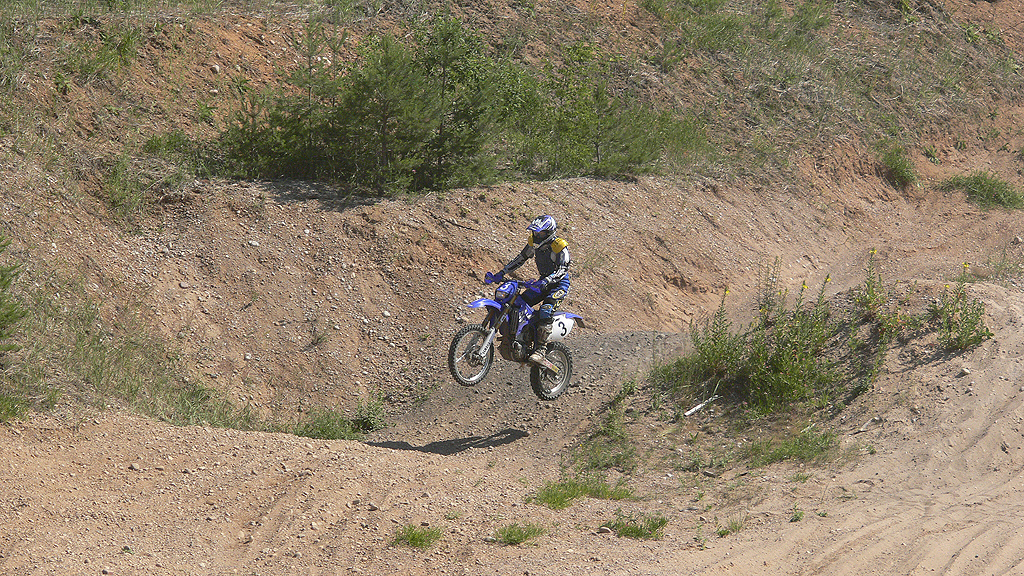

In [56]:
from IPython.display import Image
Image(filename=imgfile) 

In [57]:
# with open("test_inputs/{}".format(test_images[0]), "rb") as f:
with open(imgfile, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

response = client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/x-image", Body=payload
)    

# `response` comes in a json format, let's unpack it.
result = json.loads(response["Body"].read())
# The result outputs the probabilities for all classes.
# Find the class with maximum probability and print the class name.
print("Model prediction is: {}".format(CLASS_LIST[np.argmax(result)]))

Model prediction is: Bike


In [58]:
result

[0.005301737226545811,
 0.9814821481704712,
 0.005818361882120371,
 0.0007909036357887089,
 0.006606870796531439]

Finally, let's clean up and delete this endpoint.

In [59]:
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '6d1b0ea9-9eb7-48a8-b932-2bd1de82a57c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6d1b0ea9-9eb7-48a8-b932-2bd1de82a57c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 17 Jun 2021 19:10:38 GMT'},
  'RetryAttempts': 0}}

# Review

We covered a lot of ground in this notebook! Let's recap what we accomplished. First we started with an unlabeled dataset (technically, the dataset was previously labeled by the authors of the dataset, but we discarded the original labels for the purposes of this demonstration). Next, we created a SageMake Ground Truth labeling job and generated new labels for all of the images in our dataset. Then we split this file into a training set and a validation set and trained a SageMaker image classification model. Finally, we created a hosted model endpoint and used it to make a live prediction for a held-out image in the original dataset.